In [6]:
from scipy import signal
import numpy as np
from scipy.fftpack import fft, ifft
import pandas as pd

import matplotlib
matplotlib.use('nbagg')
from pylab import rcParams
rcParams['figure.figsize'] = 9, 4
import matplotlib.pyplot as plt
import scipy

%load_ext autoreload
%autoreload 2
import sys
import copy

from pyha import Hardware, simulate, sims_close, Complex, resize, hardware_sims_equal
from pathlib import Path
from data import load_iq

def imshow(im):
    from skimage.exposure import exposure
    p2, p98 = np.percentile(im, (2, 98))
    im = exposure.rescale_intensity(im, in_range=(p2, p98))

    
    plt.imshow(im, interpolation='nearest', aspect='auto', origin='lower')
    plt.tight_layout()
    plt.show()
    
def awgn(iq, scale):
    r =  iq
    # r = np.copy(iq)
    r.real += np.random.normal(scale=scale, size=iq.shape)
    r.imag += np.random.normal(scale=scale, size=iq.shape)
    return r
    
    
def snr(pure, noisy):
    sig_pow = np.nanmean(np.abs(pure))
    error = np.array(pure) - np.array(noisy)
    err_pow = np.nanmean(np.abs(error))
    
    snr_db = 20*np.log10(sig_pow/err_pow)
    return snr_db

from under_construction.fft.bit_reversal_fftshift import bit_reversed_indexes
from under_construction.fft.fft_core import R2SDF
from under_construction.fft.packager import DataWithIndex, unpackage, package

def show_freqz(taps):
    w, h = scipy.signal.freqz(taps)
    fig, ax1 = plt.subplots(1, 1)
    plt.title('Digital filter frequency response')
    ax1.plot(w / np.pi, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency')
    plt.grid()
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w / np.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.axis('tight')
    plt.tight_layout()
    plt.show()
    
def show_plot():
    plt.tight_layout()
    plt.grid()
    if plt.gca().get_legend_handles_labels() != ([], []):
        plt.legend()
    plt.show()
    
def bit_reverse(x, n_bits):
    return int(np.binary_repr(x, n_bits)[::-1], 2)

def bit_reversed_indexes(N):
    return [bit_reverse(i, int(np.log2(N))) for i in range(N)]

def postprocess(x):
    pyh = x
    pyh = pyh[bit_reversed_indexes(fft_size)]
    pyh = np.fft.fftshift(pyh)
    pyh = [complex(x) for x in pyh]
#     pyh = np.abs(pyh)
    pyh = pyh * np.conjugate(pyh)
#     pyh = pyh / pyh.max()
    return pyh.real

    a = 20 * np.log10(pyh 
#                       + 0.0000000000000000000001
                     ) # add small number to avoid div by 0
    return a


from pyha import Hardware, simulate, sims_close, Complex, Sfix, scalb

results = {}
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# SNR: 27.808717953912666 (full prec)
# SNR: 27.934033216930448 (10 twid, 8 window)
# SNR: 27.42276405103311 (9 twid, 8 window)

In [30]:
with open('/home/gaspar/Documents/low_power_ph3.raw_spectro_TST.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data = pickle.load(f)

In [31]:
for x in np.array(data['PYHA']):
    print(len(x))
    
    

256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
88


In [32]:
p = np.array(data['PYHA'][:-1])
p.shape

(61, 256)

<IPython.core.display.Javascript object>


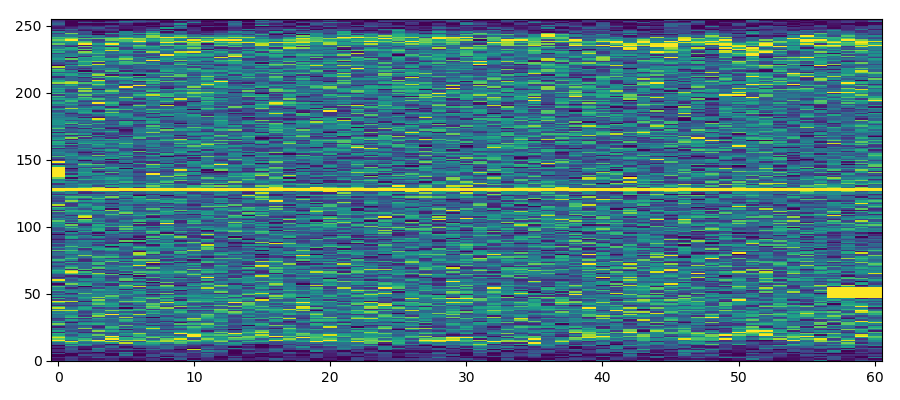

In [33]:
imshow(p.T)

<IPython.core.display.Javascript object>


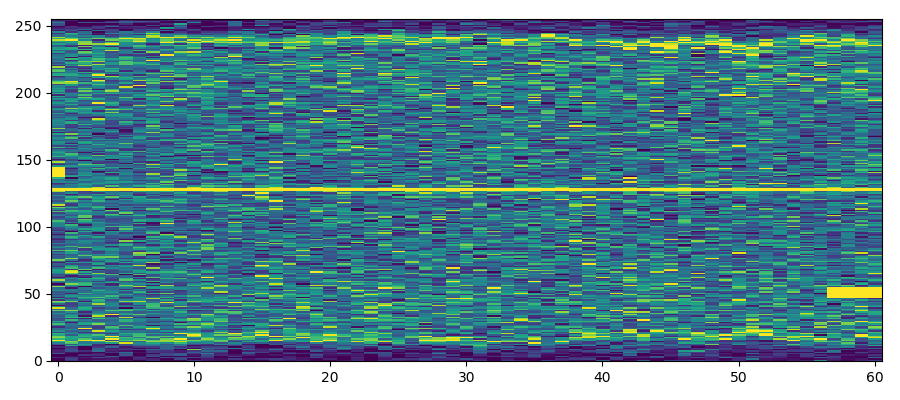

In [9]:
imshow(np.array(data['MODEL']).T)

In [34]:
m = np.array(data['MODEL']).T
m = m / m.max()
print(m.shape)
p = np.array(data['PYHA'][:-1]).T
print(p.shape)
p = p / p.max()
print(p.shape)

print(p.shape)
print(snr(m[0], p[0]))

(256, 61)
(256, 61)
(256, 61)
(256, 61)
15.574974744369428


<IPython.core.display.Javascript object>


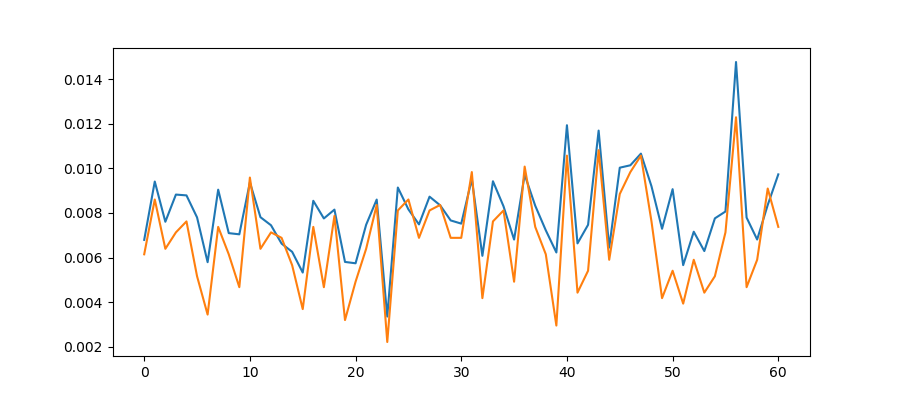

In [35]:
plt.plot(m[0])
plt.plot(p[0])
plt.show()

In [37]:
np.array(data['MODEL']).max()

4.030379932373762e-05

<IPython.core.display.Javascript object>


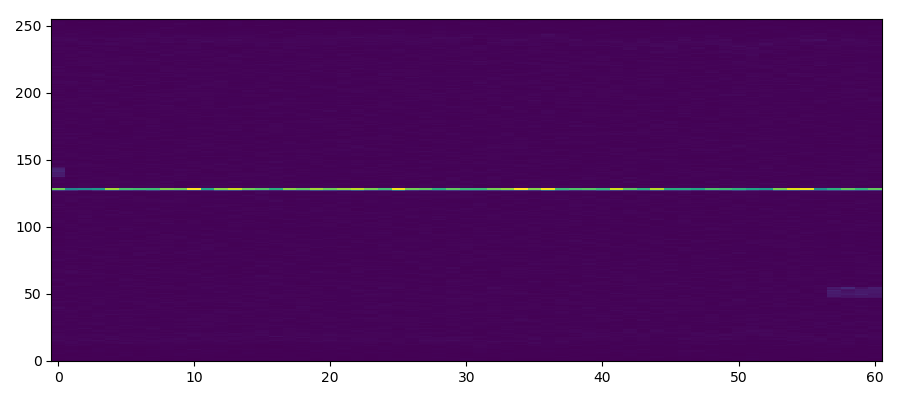

In [27]:
plt.imshow(np.array(data['MODEL']).T, interpolation='nearest', aspect='auto', origin='lower')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


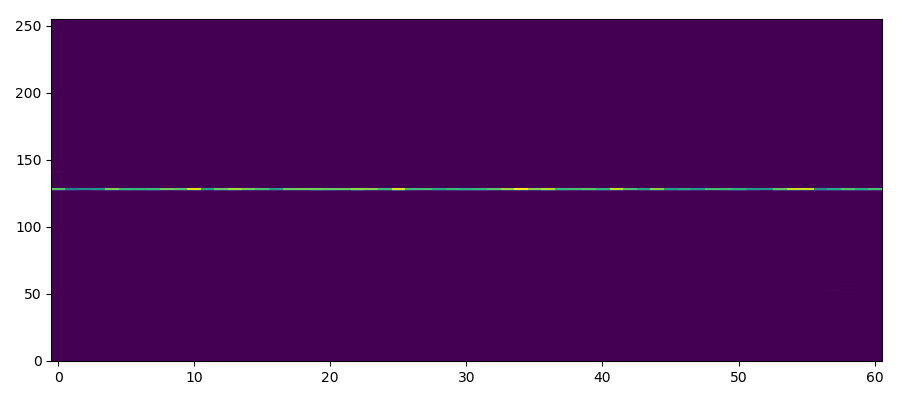

In [29]:
plt.imshow(np.array(data['PYHA'][:-1]).T, interpolation='nearest', aspect='auto', origin='lower')
plt.tight_layout()
plt.show()

In [47]:
file = '/home/gaspar/Documents/low_power_ph3.raw'
fft_size = 1024 * 2 * 2 * 2
decimation = 32
print(file)

iq = load_iq(file)
# iq = iq[:fft_size*120]

/home/gaspar/Documents/low_power_ph3.raw


In [42]:
x = iq.reshape(-1, fft_size)
ffts = np.fft.fft(iq, fft_size)

In [43]:
ffts.max()

(0.2852551916503185-0.050701356299814676j)

In [48]:
from under_construction.fft.spectrogram import Spectrogram
from under_construction.fft.bitreversal_fftshift_decimate import BitreversalFFTshiftDecimate
from under_construction.fft.packager import Packager, DataWithIndex, unpackage, package
dut = Spectrogram(fft_size, decimation)
sims = simulate(dut, iq, simulations=['MODEL', 'PYHA'],
                output_callback=unpackage)

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...


  4%|▍         | 44393/999467 [00:50<17:56, 886.87it/s] 

INFO:sim:Running "PYHA" simulation...



  0%|          | 15463/4014827 [00:13<58:46, 1133.99it/s]


  1%|          | 31332/4014827 [00:27<57:42, 1150.41it/s]


  1%|          | 47389/4014827 [00:40<56:57, 1161.05it/s]


  2%|▏         | 63261/4014827 [00:54<56:42, 1161.30it/s]


  2%|▏         | 78912/4014827 [01:08<56:38, 1158.28it/s]


  2%|▏         | 94653/4014827 [01:21<56:26, 1157.71it/s]


  3%|▎         | 110222/4014827 [01:35<56:11, 1158.00it/s]


  3%|▎         | 125856/4014827 [01:48<55:56, 1158.77it/s]


  4%|▎         | 141640/4014827 [02:02<55:36, 1160.68it/s]


  4%|▍         | 157269/4014827 [02:15<55:21, 1161.32it/s]


  4%|▍         | 172980/4014827 [02:28<55:05, 1162.31it/s]


  5%|▍         | 188628/4014827 [02:42<54:50, 1162.69it/s]


  5%|▌         | 204162/4014827 [02:55<54:38, 1162.19it/s]


  5%|▌         | 219676/4014827 [03:09<54:26, 1161.77it/s]


  6%|▌         | 235477/4014827 [03:22<54:09, 1162.98it/s]


  6%|▋         | 251135/4014827 [03:35<53:55, 1163.08it/s]


  7%|▋         | 266710/4014827 [03:49<53:42, 1162.97it/s]


  7%|▋         | 282320/4014827 [04:02<53:29, 1162.80it/s]


  7%|▋         | 298039/4014827 [04:16<53:15, 1163.08it/s]


  8%|▊         | 313743/4014827 [04:29<53:01, 1163.30it/s]


  8%|▊         | 329502/4014827 [04:43<52:47, 1163.45it/s]


  9%|▊         | 345051/4014827 [04:56<52:35, 1163.02it/s]


  9%|▉         | 360874/4014827 [05:10<52:19, 1163.79it/s]


  9%|▉         | 376502/4014827 [05:23<52:06, 1163.82it/s]


 10%|▉         | 392247/4014827 [05:36<51:51, 1164.24it/s]


 10%|█         | 408003/4014827 [05:50<51:36, 1164.72it/s]


 11%|█         | 423496/4014827 [06:03<51:24, 1164.27it/s]


 11%|█         | 439299/4014827 [06:17<51:09, 1164.84it/s]


 11%|█▏        | 454997/4014827 [06:30<50:55, 1165.10it/s]


 12%|█▏        | 470765/4014827 [06:43<50:40, 1165.44it/s]


 12%|█▏        | 486562/4014827 [06:57<50:26, 1165.90it/s]


 13%|█▎        | 502417/4014827 [07:10<50:11, 1166.37it/s]


 13%|█▎        | 518387/4014827 [07:24<49:55, 1167.24it/s]


 13%|█▎        | 534328/4014827 [07:37<49:39, 1167.96it/s]


 14%|█▎        | 550209/4014827 [07:50<49:25, 1168.49it/s]


 14%|█▍        | 566248/4014827 [08:06<49:19, 1165.07it/s]


 15%|█▍        | 582220/4014827 [08:19<49:04, 1165.81it/s]


 15%|█▍        | 598180/4014827 [08:32<48:48, 1166.55it/s]


 15%|█▌        | 614261/4014827 [08:46<48:32, 1167.49it/s]


 16%|█▌        | 630192/4014827 [08:59<48:17, 1168.12it/s]


 16%|█▌        | 646162/4014827 [09:12<48:02, 1168.80it/s]


 16%|█▋        | 662019/4014827 [09:26<47:47, 1169.18it/s]


 17%|█▋        | 677981/4014827 [09:39<47:32, 1169.78it/s]


 17%|█▋        | 693950/4014827 [09:52<47:17, 1170.32it/s]


 18%|█▊        | 709967/4014827 [10:06<47:02, 1170.99it/s]


 18%|█▊        | 725949/4014827 [10:19<46:47, 1171.54it/s]


 18%|█▊        | 741906/4014827 [10:32<46:32, 1172.06it/s]


 19%|█▉        | 757946/4014827 [10:46<46:17, 1172.67it/s]


 19%|█▉        | 773836/4014827 [10:59<46:03, 1172.97it/s]


 20%|█▉        | 789623/4014827 [11:13<45:49, 1173.09it/s]


 20%|██        | 805508/4014827 [11:26<45:35, 1173.35it/s]


 20%|██        | 821399/4014827 [11:39<45:20, 1173.63it/s]


 21%|██        | 837368/4014827 [11:53<45:06, 1174.07it/s]


 21%|██▏       | 853207/4014827 [12:06<44:52, 1174.22it/s]


 22%|██▏       | 869023/4014827 [12:20<44:38, 1174.26it/s]


 22%|██▏       | 885103/4014827 [12:33<44:24, 1174.82it/s]


 22%|██▏       | 901153/4014827 [12:46<44:09, 1175.29it/s]


 23%|██▎       | 917147/4014827 [13:00<43:54, 1175.64it/s]


 23%|██▎       | 933213/4014827 [13:13<43:40, 1176.08it/s]


 24%|██▎       | 949288/4014827 [13:26<43:25, 1176.49it/s]


 24%|██▍       | 965330/4014827 [13:40<43:11, 1176.88it/s]


 24%|██▍       | 981358/4014827 [13:53<42:56, 1177.27it/s]


 25%|██▍       | 997386/4014827 [14:06<42:42, 1177.65it/s]


 25%|██▌       | 1013191/4014827 [14:20<42:28, 1178.02it/s]


 26%|██▌       | 1028980/4014827 [14:33<42:13, 1178.32it/s]


 26%|██▌       | 1044804/4014827 [14:46<41:59, 1178.69it/s]


 26%|██▋       | 1060446/4014827 [14:59<41:46, 1178.83it/s]


 27%|██▋       | 1076176/4014827 [15:12<41:32, 1179.09it/s]


 27%|██▋       | 1091974/4014827 [15:25<41:18, 1179.39it/s]


 28%|██▊       | 1107871/4014827 [15:39<41:04, 1179.77it/s]


 28%|██▊       | 1123738/4014827 [15:52<40:49, 1180.13it/s]


 28%|██▊       | 1139615/4014827 [16:05<40:35, 1180.52it/s]


 29%|██▉       | 1155487/4014827 [16:18<40:21, 1180.87it/s]


 29%|██▉       | 1171334/4014827 [16:31<40:07, 1181.18it/s]


 30%|██▉       | 1187195/4014827 [16:44<39:53, 1181.50it/s]


 30%|██▉       | 1202992/4014827 [16:57<39:39, 1181.76it/s]


 30%|███       | 1218851/4014827 [17:11<39:25, 1182.08it/s]


 31%|███       | 1234679/4014827 [17:24<39:11, 1182.37it/s]


 31%|███       | 1250497/4014827 [17:37<38:57, 1182.63it/s]


 32%|███▏      | 1266283/4014827 [17:50<38:43, 1182.82it/s]


 32%|███▏      | 1281853/4014827 [18:03<38:30, 1182.73it/s]


 32%|███▏      | 1297076/4014827 [18:17<38:18, 1182.24it/s]


 33%|███▎      | 1312604/4014827 [18:30<38:05, 1182.17it/s]


 33%|███▎      | 1327943/4014827 [18:43<37:53, 1181.80it/s]


 33%|███▎      | 1343142/4014827 [18:56<37:41, 1181.34it/s]


 34%|███▍      | 1358662/4014827 [19:10<37:28, 1181.21it/s]


 34%|███▍      | 1374504/4014827 [19:23<37:14, 1181.44it/s]


 35%|███▍      | 1390349/4014827 [19:36<37:00, 1181.73it/s]


 35%|███▌      | 1405950/4014827 [19:49<36:47, 1181.78it/s]


 35%|███▌      | 1421570/4014827 [20:02<36:34, 1181.83it/s]


 36%|███▌      | 1436837/4014827 [20:16<36:22, 1181.47it/s]


 36%|███▌      | 1452673/4014827 [20:29<36:08, 1181.72it/s]


 37%|███▋      | 1468205/4014827 [20:42<35:55, 1181.70it/s]


 37%|███▋      | 1483809/4014827 [20:55<35:41, 1181.72it/s]


 37%|███▋      | 1499517/4014827 [21:08<35:28, 1181.85it/s]


 38%|███▊      | 1515328/4014827 [21:21<35:14, 1182.02it/s]


 38%|███▊      | 1531004/4014827 [21:35<35:01, 1182.13it/s]


 39%|███▊      | 1546720/4014827 [21:48<34:47, 1182.26it/s]


 39%|███▉      | 1562441/4014827 [22:01<34:34, 1182.40it/s]


 39%|███▉      | 1578245/4014827 [22:14<34:20, 1182.56it/s]


 40%|███▉      | 1593979/4014827 [22:27<34:06, 1182.68it/s]


 40%|████      | 1609710/4014827 [22:40<33:53, 1182.81it/s]


 40%|████      | 1625388/4014827 [22:54<33:40, 1182.85it/s]


 41%|████      | 1641098/4014827 [23:07<33:26, 1182.96it/s]


 41%|████▏     | 1656766/4014827 [23:20<33:13, 1183.00it/s]


 42%|████▏     | 1672520/4014827 [23:33<32:59, 1183.11it/s]


 42%|████▏     | 1688032/4014827 [23:46<32:46, 1183.03it/s]


 42%|████▏     | 1703616/4014827 [24:00<32:33, 1183.02it/s]


 43%|████▎     | 1719304/4014827 [24:13<32:20, 1183.10it/s]


 43%|████▎     | 1735079/4014827 [24:26<32:06, 1183.23it/s]


 44%|████▎     | 1750829/4014827 [24:39<31:53, 1183.36it/s]


 44%|████▍     | 1766593/4014827 [24:52<31:39, 1183.48it/s]


 44%|████▍     | 1782385/4014827 [25:05<31:26, 1183.64it/s]


 45%|████▍     | 1798024/4014827 [25:19<31:12, 1183.65it/s]


 45%|████▌     | 1813818/4014827 [25:32<30:59, 1183.80it/s]


 46%|████▌     | 1829445/4014827 [25:47<30:48, 1182.33it/s]


 46%|████▌     | 1845086/4014827 [26:00<30:35, 1182.38it/s]


 46%|████▋     | 1860637/4014827 [26:13<30:21, 1182.38it/s]


 47%|████▋     | 1876297/4014827 [26:26<30:08, 1182.44it/s]


 47%|████▋     | 1892047/4014827 [26:39<29:55, 1182.54it/s]


 48%|████▊     | 1907747/4014827 [26:53<29:41, 1182.64it/s]


 48%|████▊     | 1923520/4014827 [27:06<29:28, 1182.77it/s]


 48%|████▊     | 1939182/4014827 [27:19<29:14, 1182.80it/s]


 49%|████▊     | 1954814/4014827 [27:32<29:01, 1182.80it/s]


 49%|████▉     | 1970391/4014827 [27:45<28:48, 1182.77it/s]


 49%|████▉     | 1986077/4014827 [27:59<28:35, 1182.84it/s]


 50%|████▉     | 2001683/4014827 [28:12<28:21, 1182.85it/s]


 50%|█████     | 2017204/4014827 [28:25<28:08, 1182.82it/s]


 51%|█████     | 2032914/4014827 [28:38<27:55, 1182.90it/s]


 51%|█████     | 2048731/4014827 [28:51<27:41, 1183.05it/s]


 51%|█████▏    | 2064412/4014827 [29:04<27:28, 1183.10it/s]


 52%|█████▏    | 2080061/4014827 [29:18<27:15, 1183.14it/s]


 52%|█████▏    | 2095762/4014827 [29:31<27:01, 1183.21it/s]


 53%|█████▎    | 2111484/4014827 [29:44<26:48, 1183.30it/s]


 53%|█████▎    | 2127351/4014827 [29:57<26:34, 1183.48it/s]


 53%|█████▎    | 2143011/4014827 [30:10<26:21, 1183.53it/s]


 54%|█████▍    | 2158716/4014827 [30:23<26:08, 1183.60it/s]


 54%|█████▍    | 2174421/4014827 [30:37<25:54, 1183.68it/s]


 55%|█████▍    | 2190228/4014827 [30:50<25:41, 1183.82it/s]


 55%|█████▍    | 2205895/4014827 [31:03<25:28, 1183.85it/s]


 55%|█████▌    | 2221550/4014827 [31:16<25:14, 1183.89it/s]


 56%|█████▌    | 2237201/4014827 [31:29<25:01, 1183.92it/s]


 56%|█████▌    | 2252856/4014827 [31:42<24:48, 1183.96it/s]


 57%|█████▋    | 2268659/4014827 [31:55<24:34, 1184.08it/s]


 57%|█████▋    | 2284229/4014827 [32:09<24:21, 1184.05it/s]


 57%|█████▋    | 2299808/4014827 [32:22<24:08, 1184.03it/s]


 58%|█████▊    | 2315611/4014827 [32:35<23:54, 1184.15it/s]


 58%|█████▊    | 2330892/4014827 [32:48<23:42, 1183.86it/s]


 58%|█████▊    | 2346539/4014827 [33:02<23:29, 1183.85it/s]


 59%|█████▉    | 2360801/4014827 [33:15<23:18, 1182.95it/s]


 59%|█████▉    | 2375645/4014827 [33:28<23:06, 1182.52it/s]


 60%|█████▉    | 2390530/4014827 [33:42<22:54, 1182.08it/s]


 60%|█████▉    | 2405257/4014827 [33:55<22:42, 1181.55it/s]


 60%|██████    | 2420476/4014827 [34:08<22:29, 1181.33it/s]


 61%|██████    | 2435702/4014827 [34:22<22:16, 1181.11it/s]


 61%|██████    | 2451229/4014827 [34:35<22:03, 1181.10it/s]


 61%|██████▏   | 2466740/4014827 [34:48<21:50, 1181.04it/s]


 62%|██████▏   | 2482314/4014827 [35:01<21:37, 1181.05it/s]


 62%|██████▏   | 2497871/4014827 [35:15<21:24, 1181.02it/s]


 63%|██████▎   | 2513467/4014827 [35:28<21:11, 1181.04it/s]


 63%|██████▎   | 2528971/4014827 [35:41<20:58, 1180.99it/s]


 63%|██████▎   | 2544445/4014827 [35:54<20:45, 1180.95it/s]


 64%|██████▍   | 2559917/4014827 [36:07<20:32, 1180.91it/s]


 64%|██████▍   | 2575461/4014827 [36:20<20:18, 1180.90it/s]


 65%|██████▍   | 2590960/4014827 [36:34<20:05, 1180.88it/s]


 65%|██████▍   | 2606460/4014827 [36:47<19:52, 1180.84it/s]


 65%|██████▌   | 2621381/4014827 [37:00<19:40, 1180.46it/s]


 66%|██████▌   | 2636552/4014827 [37:13<19:27, 1180.24it/s]


 66%|██████▌   | 2651994/4014827 [37:27<19:14, 1180.17it/s]


 66%|██████▋   | 2667642/4014827 [37:40<19:01, 1180.22it/s]


 67%|██████▋   | 2682936/4014827 [37:53<18:48, 1180.05it/s]


 67%|██████▋   | 2698488/4014827 [38:06<18:35, 1180.04it/s]


 68%|██████▊   | 2713965/4014827 [38:19<18:22, 1180.01it/s]


 68%|██████▊   | 2729465/4014827 [38:33<18:09, 1180.00it/s]


 68%|██████▊   | 2745159/4014827 [38:46<17:55, 1180.07it/s]


 69%|██████▉   | 2760537/4014827 [38:59<17:42, 1179.97it/s]


 69%|██████▉   | 2776084/4014827 [39:12<17:29, 1179.95it/s]


 70%|██████▉   | 2791588/4014827 [39:25<17:16, 1179.93it/s]


 70%|██████▉   | 2807109/4014827 [39:39<17:03, 1179.91it/s]


 70%|███████   | 2822681/4014827 [39:52<16:50, 1179.91it/s]


 71%|███████   | 2838205/4014827 [40:05<16:37, 1179.91it/s]


 71%|███████   | 2853820/4014827 [40:18<16:23, 1179.94it/s]


 71%|███████▏  | 2869246/4014827 [40:31<16:10, 1179.90it/s]


 72%|███████▏  | 2884860/4014827 [40:44<15:57, 1179.93it/s]


 72%|███████▏  | 2900492/4014827 [40:58<15:44, 1179.98it/s]


 73%|███████▎  | 2916114/4014827 [41:11<15:31, 1180.02it/s]


 73%|███████▎  | 2931758/4014827 [41:24<15:17, 1180.07it/s]


 73%|███████▎  | 2947355/4014827 [41:37<15:04, 1180.09it/s]


 74%|███████▍  | 2962537/4014827 [41:50<14:51, 1179.89it/s]


 74%|███████▍  | 2977844/4014827 [42:04<14:38, 1179.76it/s]


 75%|███████▍  | 2993286/4014827 [42:17<14:25, 1179.72it/s]


 75%|███████▍  | 3008474/4014827 [42:30<14:13, 1179.54it/s]


 75%|███████▌  | 3023765/4014827 [42:43<14:00, 1179.41it/s]


 76%|███████▌  | 3039102/4014827 [42:57<13:47, 1179.32it/s]


 76%|███████▌  | 3054697/4014827 [43:10<13:34, 1179.35it/s]


 76%|███████▋  | 3070246/4014827 [43:23<13:20, 1179.35it/s]


 77%|███████▋  | 3085849/4014827 [43:36<13:07, 1179.37it/s]


 77%|███████▋  | 3101449/4014827 [43:49<12:54, 1179.40it/s]


 78%|███████▊  | 3117052/4014827 [44:02<12:41, 1179.43it/s]


 78%|███████▊  | 3132618/4014827 [44:16<12:27, 1179.44it/s]


 78%|███████▊  | 3148151/4014827 [44:29<12:14, 1179.43it/s]


 79%|███████▉  | 3163699/4014827 [44:44<12:02, 1178.56it/s]


 79%|███████▉  | 3179283/4014827 [44:57<11:48, 1178.58it/s]


 80%|███████▉  | 3194904/4014827 [45:10<11:35, 1178.62it/s]


 80%|███████▉  | 3210094/4014827 [45:24<11:22, 1178.43it/s]


 80%|████████  | 3225162/4014827 [45:37<11:10, 1178.15it/s]


 81%|████████  | 3240632/4014827 [45:50<10:57, 1178.12it/s]


 81%|████████  | 3256052/4014827 [46:03<10:44, 1178.08it/s]


 81%|████████▏ | 3271588/4014827 [46:17<10:30, 1178.10it/s]


 82%|████████▏ | 3287145/4014827 [46:30<10:17, 1178.10it/s]


 82%|████████▏ | 3302242/4014827 [46:43<10:04, 1177.88it/s]


 83%|████████▎ | 3317376/4014827 [46:56<09:52, 1177.71it/s]


 83%|████████▎ | 3332220/4014827 [47:10<09:39, 1177.38it/s]


 83%|████████▎ | 3347237/4014827 [47:23<09:27, 1177.14it/s]


 84%|████████▎ | 3362357/4014827 [47:36<09:14, 1176.94it/s]


 84%|████████▍ | 3377680/4014827 [47:50<09:01, 1176.86it/s]


 85%|████████▍ | 3393061/4014827 [48:03<08:48, 1176.79it/s]


 85%|████████▍ | 3408232/4014827 [48:16<08:35, 1176.62it/s]


 85%|████████▌ | 3422865/4014827 [48:30<08:23, 1176.19it/s]


 86%|████████▌ | 3437896/4014827 [48:43<08:10, 1175.96it/s]


 86%|████████▌ | 3453375/4014827 [48:56<07:57, 1175.94it/s]


 86%|████████▋ | 3468899/4014827 [49:09<07:44, 1175.95it/s]


 87%|████████▋ | 3484376/4014827 [49:23<07:31, 1175.93it/s]


 87%|████████▋ | 3499812/4014827 [49:36<07:17, 1175.87it/s]


 88%|████████▊ | 3515259/4014827 [49:49<07:04, 1175.86it/s]


 88%|████████▊ | 3530594/4014827 [50:02<06:51, 1175.78it/s]


 88%|████████▊ | 3546103/4014827 [50:15<06:38, 1175.78it/s]


 89%|████████▊ | 3561714/4014827 [50:29<06:25, 1175.83it/s]


 89%|████████▉ | 3577271/4014827 [50:42<06:12, 1175.85it/s]


 89%|████████▉ | 3592940/4014827 [50:55<05:58, 1175.92it/s]


 90%|████████▉ | 3608527/4014827 [51:08<05:45, 1175.95it/s]


 90%|█████████ | 3624133/4014827 [51:21<05:32, 1176.00it/s]


 91%|█████████ | 3639491/4014827 [51:35<05:19, 1175.92it/s]


 91%|█████████ | 3654524/4014827 [51:48<05:06, 1175.75it/s]


 91%|█████████▏| 3669749/4014827 [52:01<04:53, 1175.66it/s]


 92%|█████████▏| 3684838/4014827 [52:14<04:40, 1175.50it/s]


 92%|█████████▏| 3700270/4014827 [52:27<04:27, 1175.47it/s]


 93%|█████████▎| 3715740/4014827 [52:41<04:14, 1175.46it/s]


 93%|█████████▎| 3731339/4014827 [52:54<04:01, 1175.50it/s]


 93%|█████████▎| 3746982/4014827 [53:07<03:47, 1175.55it/s]


 94%|█████████▎| 3762380/4014827 [53:20<03:34, 1175.49it/s]


 94%|█████████▍| 3777939/4014827 [53:33<03:21, 1175.52it/s]


 94%|█████████▍| 3793406/4014827 [53:47<03:08, 1175.52it/s]


 95%|█████████▍| 3808937/4014827 [54:00<02:55, 1175.54it/s]


 95%|█████████▌| 3824543/4014827 [54:13<02:41, 1175.57it/s]


 96%|█████████▌| 3840101/4014827 [54:26<02:28, 1175.59it/s]


 96%|█████████▌| 3855480/4014827 [54:39<02:15, 1175.55it/s]


 96%|█████████▋| 3871045/4014827 [54:52<02:02, 1175.58it/s]


 97%|█████████▋| 3886631/4014827 [55:06<01:49, 1175.60it/s]


 97%|█████████▋| 3902241/4014827 [55:19<01:35, 1175.64it/s]


 98%|█████████▊| 3917883/4014827 [55:32<01:22, 1175.68it/s]


 98%|█████████▊| 3933180/4014827 [55:45<01:09, 1175.61it/s]


 98%|█████████▊| 3948412/4014827 [55:58<00:56, 1175.49it/s]


 99%|█████████▊| 3963736/4014827 [56:12<00:43, 1175.42it/s]


 99%|█████████▉| 3979065/4014827 [56:25<00:30, 1175.35it/s]


 99%|█████████▉| 3994683/4014827 [56:38<00:17, 1175.40it/s]


100%|█████████▉| 4010171/4014827 [56:51<00:03, 1175.40it/s]


100%|██████████| 4014827/4014827 [56:56<00:00, 1175.24it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!
